In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import time

import os
import shutil

## Problem Description

This project uses generative adversarial networks (GANs) to modify a set of images to look like Claude Monet images. This is a Kaggle competition at https://www.kaggle.com/competitions/gan-getting-started.

GAN architectures rely on two copmeting models: a generator and a discriminator. The generator creates the new images, learning over time to make them more Monet-like. The discriminator is trained to identify real and fake images. These two models go back and forth during training, the generator creating increasingly Monet-like images, and the discriminator calling out the fake images. Eventually the created images are good enough that the discriminator can no longer distinguish real from fake images. At this point, our GAN is able to create lifelike or Monet-like images that are indistinguishable from real ones, at least to the discriminator.

This project has a set of Monet images and a set of images that we need to modify with the GAN to look like Monet images. We will explore both sets of images before turning to architecting, training, and evaluating GANs.

The competition asks us to submit a zipped collection of generated images in order to receive a score.

## Preprocessing & Exploratory Data Analysis (EDA)

This competition provides both sets of images as JPGs and as TensorFlow TFRecord file formats for storing a sequence of binary records. We will work with the TFRecords to figure out how that format works.

TFRecords serialize structured data into binary strings. We need to know what features or keys exists for each element in the TFRecord collection. The images we are working with here have three features: `image_name`, `image`, and `target`. These are set when turning data into the TFRecord format.

The Kaggle documentation tells us that the images are all 256 x 256 pixels and are color images with the standard three RGB channels.

In [2]:
in_dir = '/kaggle/input/gan-getting-started'
out_dir = '/kaggle/working'

monet_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/monet_tfrec')
monet_jpg_names = tf.io.gfile.listdir(f'{in_dir}/monet_jpg')
photo_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/photo_tfrec')
photo_jpg_names = tf.io.gfile.listdir(f'{in_dir}/photo_jpg')

print(f'There are {len(monet_tfrec_names)} Monet TFRecord collections')
print(f'There are {len(monet_jpg_names)} Monet jpgs in total')
print(f'There are {len(photo_tfrec_names)} photo TFRecord collections')
print(f'There are {len(photo_jpg_names):,} photo jpgs in total')
print()
print(f'Sample of what the TFRecord files look like: {monet_tfrec_names}')

There are 5 Monet TFRecord collections
There are 300 Monet jpgs in total
There are 20 photo TFRecord collections
There are 7,038 photo jpgs in total

Sample of what the TFRecord files look like: ['monet12-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet00-60.tfrec']


In [3]:
# Find what the current tfrec files are storing as features for each record
ex = tf.train.Example()
ex.ParseFromString(
    next(iter(tf.data.TFRecordDataset(f'{in_dir}/monet_tfrec/{monet_tfrec_names[0]}').take(1))).numpy()
)
[k for k in ex.features.feature.keys()]

['target', 'image_name', 'image']

In [4]:
# Extract records from tfrec files into TFRecordDataset collection
tfrecs_monet = tf.data.TFRecordDataset([f'{in_dir}/monet_tfrec/{f}' for f in monet_tfrec_names])
tfrecs_photo = tf.data.TFRecordDataset([f'{in_dir}/photo_tfrec/{f}' for f in photo_tfrec_names])
    
# Define the features of the structured data stored in the TFRecord collections
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string)
    , 'image': tf.io.FixedLenFeature([], tf.string)
    , 'target': tf.io.FixedLenFeature([], tf.string)
    
}

# Pull image data out of individual TFRecord elements as dictionary mappings
# and then convert to iamges
def parse_image(record):
    img = tf.io.parse_single_example(record, feature_description)['image']
    img = tf.io.decode_image(
        img
        , channels=3
    )
    img = tf.cast(img, tf.float32) / 255.0

    return img

parsed_images_monet = tfrecs_monet.map(parse_image)
parsed_images_photo = tfrecs_photo.map(parse_image)

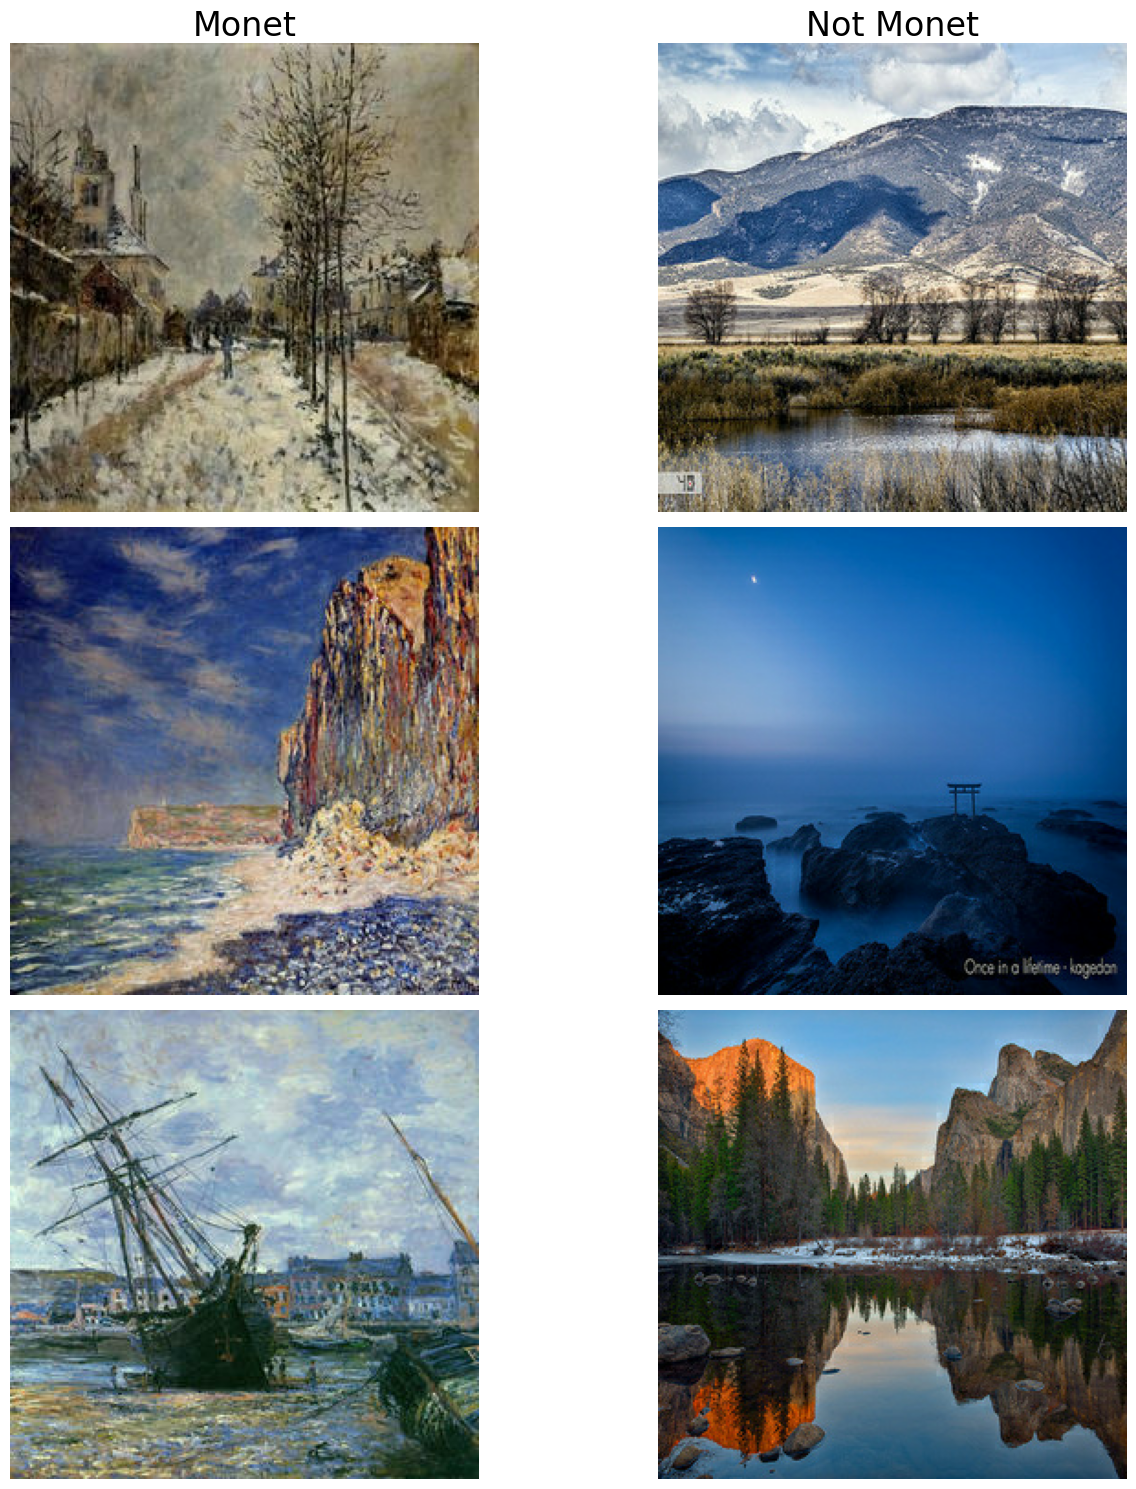

In [5]:
# Display Monet and non-Monet images
fig, axes = plt.subplots(
    3
    , 2
    , figsize=(15,15)
)

iter_monet = iter(parsed_images_monet)
iter_photo = iter(parsed_images_photo)

axes[0,0].imshow(next(iter_monet))
axes[0,1].imshow(next(iter_photo))
axes[1,0].imshow(next(iter_monet))
axes[1,1].imshow(next(iter_photo))
axes[2,0].imshow(next(iter_monet))
axes[2,1].imshow(next(iter_photo))

axes[0,0].set_title('Monet', fontsize=24)
axes[0,1].set_title('Not Monet', fontsize=24)

# Turn axis labels and grids off
for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()

We are working with 300 Monet images and 7,038 non-Monet images. The two images above show Monets on the left and non-Monets on the right. The gist of the code above extracts the TFRecord collections into TFRecordDataset datasets and pulls the image pixel data out of each element in the collections.

Next we will explore a couple of aspects of the images to see if we can find a foothold for understanding what makes them up.

I am still working on how to do the next couple of code blocks in TensorFlow, so we will use Numpy in the interim.

`parsed_images_monet` and `parsed_images_photo` are collections of TensorFlow tensors of shape (256, 256, 3). This is what we expect to see based on the Kaggle documentation. We have a 256 x 256 px image with each cell being a 3 dimensional array for the RGB channels. The general approach for the next couple of check will be to see if there are differences between the Monet and non-Monet images in terms of sums or means of values across different dimensions of the tensors.

We will get a sense of what we are working with before moving on to calculating and exploring descriptive statistics for each of the sets of images.

In [6]:
list_monet = np.array([i for i in parsed_images_monet])
list_photo = np.array([i for i in parsed_images_photo])

print(f'Dimensions of Monet image collection: {list_monet.shape}')
print(f'Dimensions of photo image collection: {list_photo.shape}')
print(f'Dimensions of first individual Monet image: {list_monet[0].shape}')
print(f'Dimensions of first individual Monet image: {list_photo[0].shape}')

list_monet[0]

Dimensions of Monet image collection: (300, 256, 256, 3)
Dimensions of photo image collection: (7038, 256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)


array([[[0.5411765 , 0.49019608, 0.41568628],
        [0.48235294, 0.43137255, 0.35686275],
        [0.4392157 , 0.39607844, 0.3254902 ],
        ...,
        [0.45490196, 0.39607844, 0.26666668],
        [0.4392157 , 0.38431373, 0.23921569],
        [0.42352942, 0.36862746, 0.22352941]],

       [[0.5568628 , 0.5058824 , 0.43137255],
        [0.5294118 , 0.47843137, 0.40392157],
        [0.50980395, 0.46666667, 0.39607844],
        ...,
        [0.53333336, 0.4745098 , 0.34509805],
        [0.50980395, 0.45490196, 0.30980393],
        [0.4862745 , 0.43137255, 0.28627452]],

       [[0.5529412 , 0.5019608 , 0.42745098],
        [0.5529412 , 0.5019608 , 0.42745098],
        [0.56078434, 0.5176471 , 0.44705883],
        ...,
        [0.5882353 , 0.5294118 , 0.4       ],
        [0.5568628 , 0.5019608 , 0.3647059 ],
        [0.5294118 , 0.4745098 , 0.32941177]],

       ...,

       [[0.39607844, 0.34509805, 0.21960784],
        [0.4627451 , 0.4117647 , 0.28627452],
        [0.4117647 , 0

In [7]:
print(f'Example sum of all pixels in image: {np.sum(list_monet[0]):,}')
print(f'Example sum of red channel in image: {np.sum(list_monet[0][:,:,0]):,}')
print(f'Example sum of green channel in image: {np.sum(list_monet[0][:,:,1]):,}')
print(f'Example sum of blue channel in image: {np.sum(list_monet[0][:,:,2]):,}')
print(f'Sanity check: {np.sum(list_monet[0][:,:,0]) + np.sum(list_monet[0][:,:,1]) + np.sum(list_monet[0][:,:,2]):,}')
print(f'Example mean of all pixels in image: {np.mean(list_monet[0]):.2f}')
print(f'Example mean of red channel in image: {np.mean(list_monet[0][:,:,0]):.2f}')
print(f'Example mean of green channel in image: {np.mean(list_monet[0][:,:,1]):.2f}')
print(f'Example mean of blue channel in image: {np.mean(list_monet[0][:,:,2]):.2f}')

Example sum of all pixels in image: 87,802.21875
Example sum of red channel in image: 32,173.89453125
Example sum of green channel in image: 30,454.978515625
Example sum of blue channel in image: 25,173.345703125
Sanity check: 87,802.21875
Example mean of all pixels in image: 0.45
Example mean of red channel in image: 0.49
Example mean of green channel in image: 0.46
Example mean of blue channel in image: 0.38


I went back and forth on what type exploratory analysis to perform before jumping into GAN modeling. We do not have a label breakdown to check for imbalance. We do not have other classifiers to aggregate against for the training inputs. But we can take a look at the pixel values that create the Monet images and the non-Monet images. For example, we may find that the Monet images tend to have stronger pixel values in the red and blue channels but smaller values in the green channel. This may or may not be useful when comparing against the non-Monet images. Similarly, we may find that the overall pixel mean per image is different between the two sets of images.

We will check out the sum and mean for images across all channels and across each of the RGB channels.

In [8]:
num_images_monet = list_monet.shape[0]
num_images_photo = list_photo.shape[0]

sum_all_channels_monet = []
sum_red_channel_monet = []
sum_green_channel_monet = []
sum_blue_channel_monet = []
mean_all_channels_monet = []
mean_red_channel_monet = []
mean_green_channel_monet = []
mean_blue_channel_monet = []

sum_all_channels_photo = []
sum_red_channel_photo = []
sum_green_channel_photo = []
sum_blue_channel_photo = []
mean_all_channels_photo = []
mean_red_channel_photo = []
mean_green_channel_photo = []
mean_blue_channel_photo = []

for img in list_monet:
    sum_all_channels_monet.append(np.sum(img))
    sum_red_channel_monet.append(np.sum(img[:,:,0]))
    sum_green_channel_monet.append(np.sum(img[:,:,1]))
    sum_blue_channel_monet.append(np.sum(img[:,:,2]))
    mean_all_channels_monet.append(np.mean(img))
    mean_red_channel_monet.append(np.mean(img[:,:,0]))
    mean_green_channel_monet.append(np.mean(img[:,:,1]))
    mean_blue_channel_monet.append(np.mean(img[:,:,2]))

for img in list_photo:
    sum_all_channels_photo.append(np.sum(img))
    sum_red_channel_photo.append(np.sum(img[:,:,0]))
    sum_green_channel_photo.append(np.sum(img[:,:,1]))
    sum_blue_channel_photo.append(np.sum(img[:,:,2]))
    mean_all_channels_photo.append(np.mean(img))
    mean_red_channel_photo.append(np.mean(img[:,:,0]))
    mean_green_channel_photo.append(np.mean(img[:,:,1]))
    mean_blue_channel_photo.append(np.mean(img[:,:,2]))

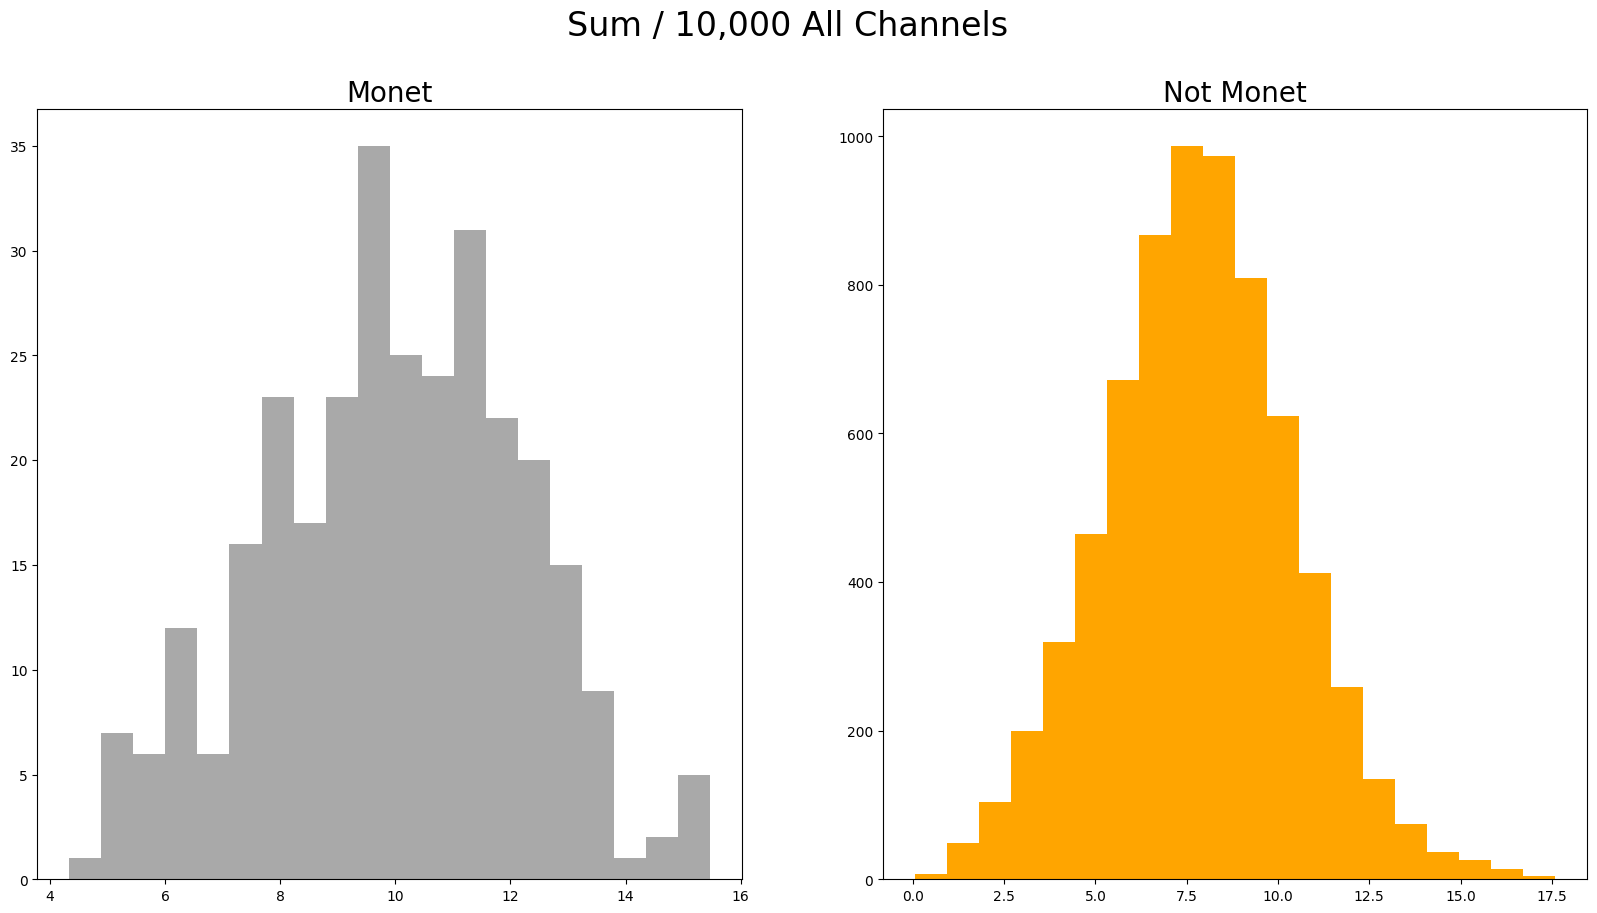

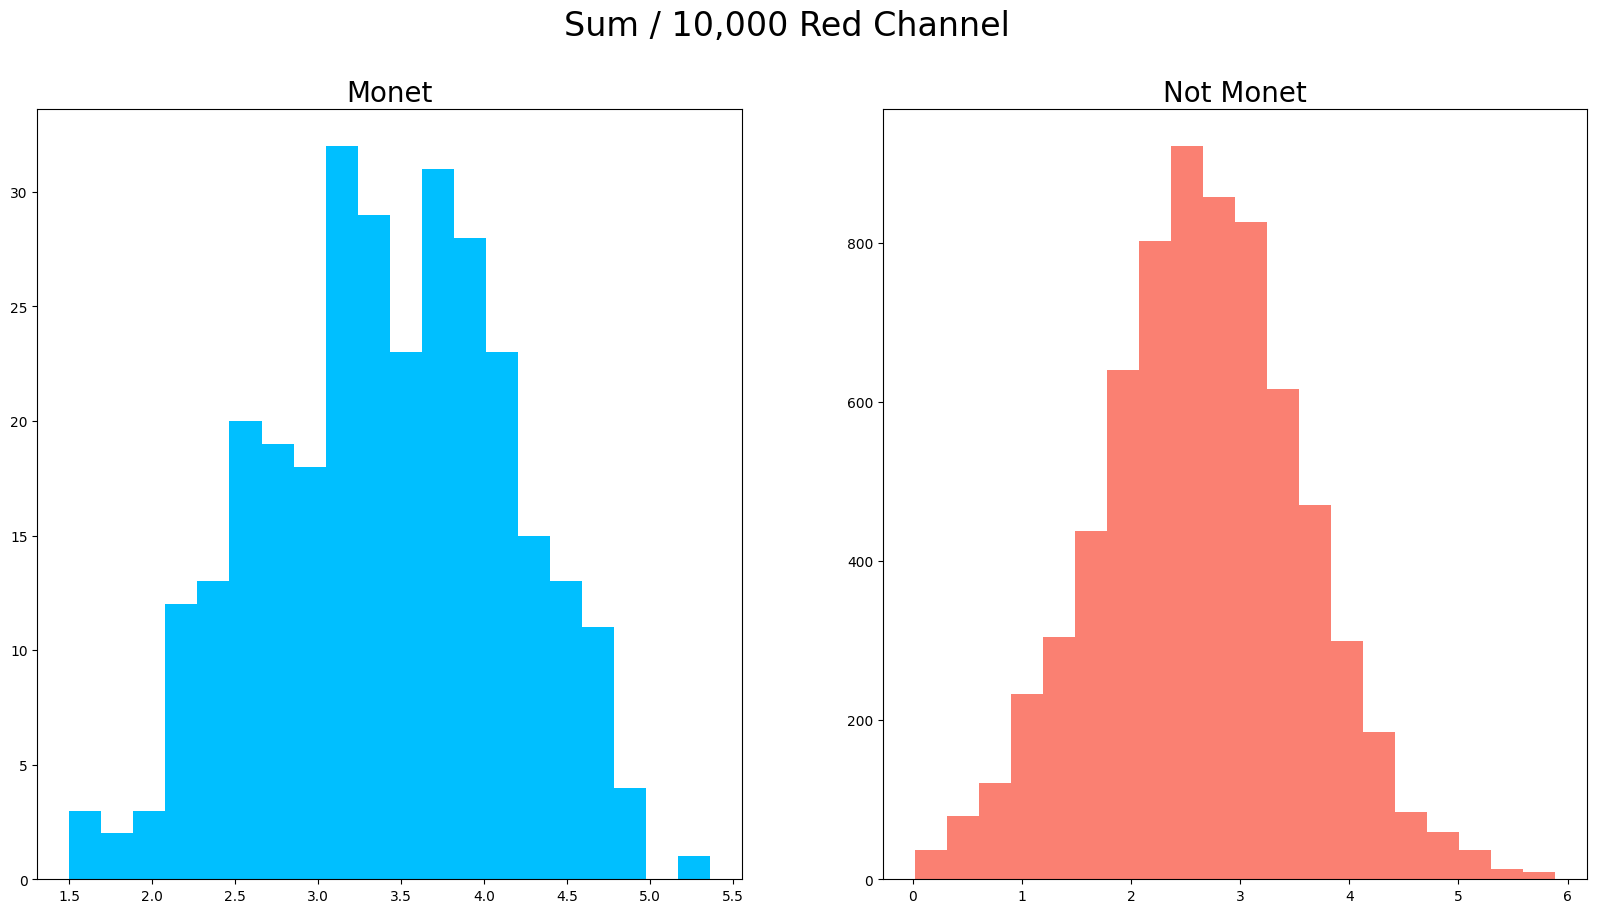

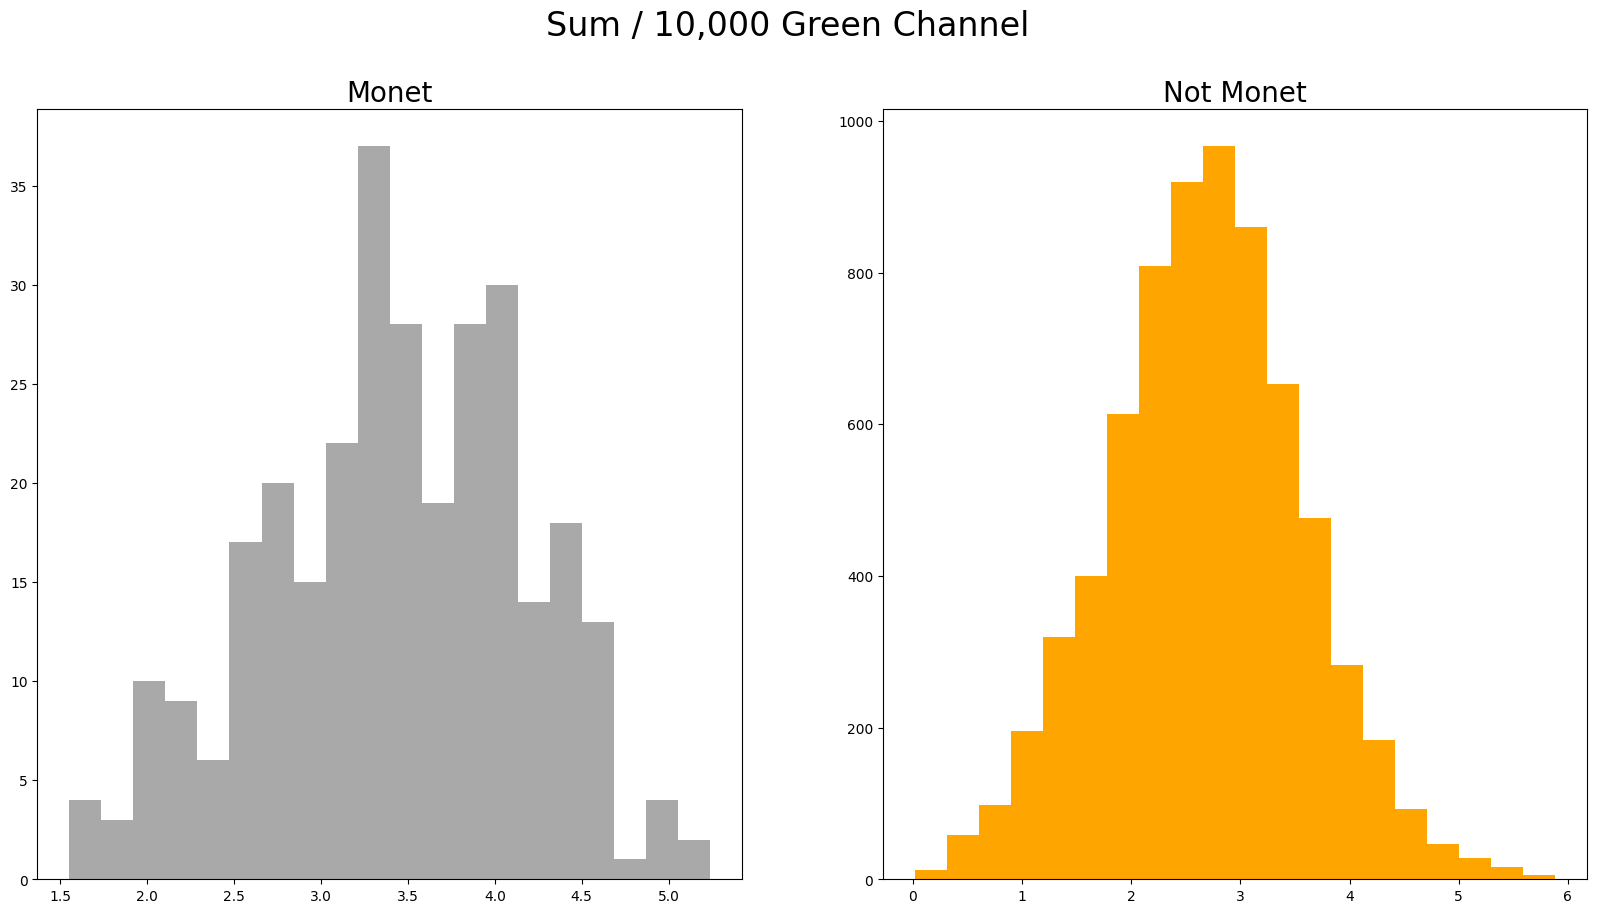

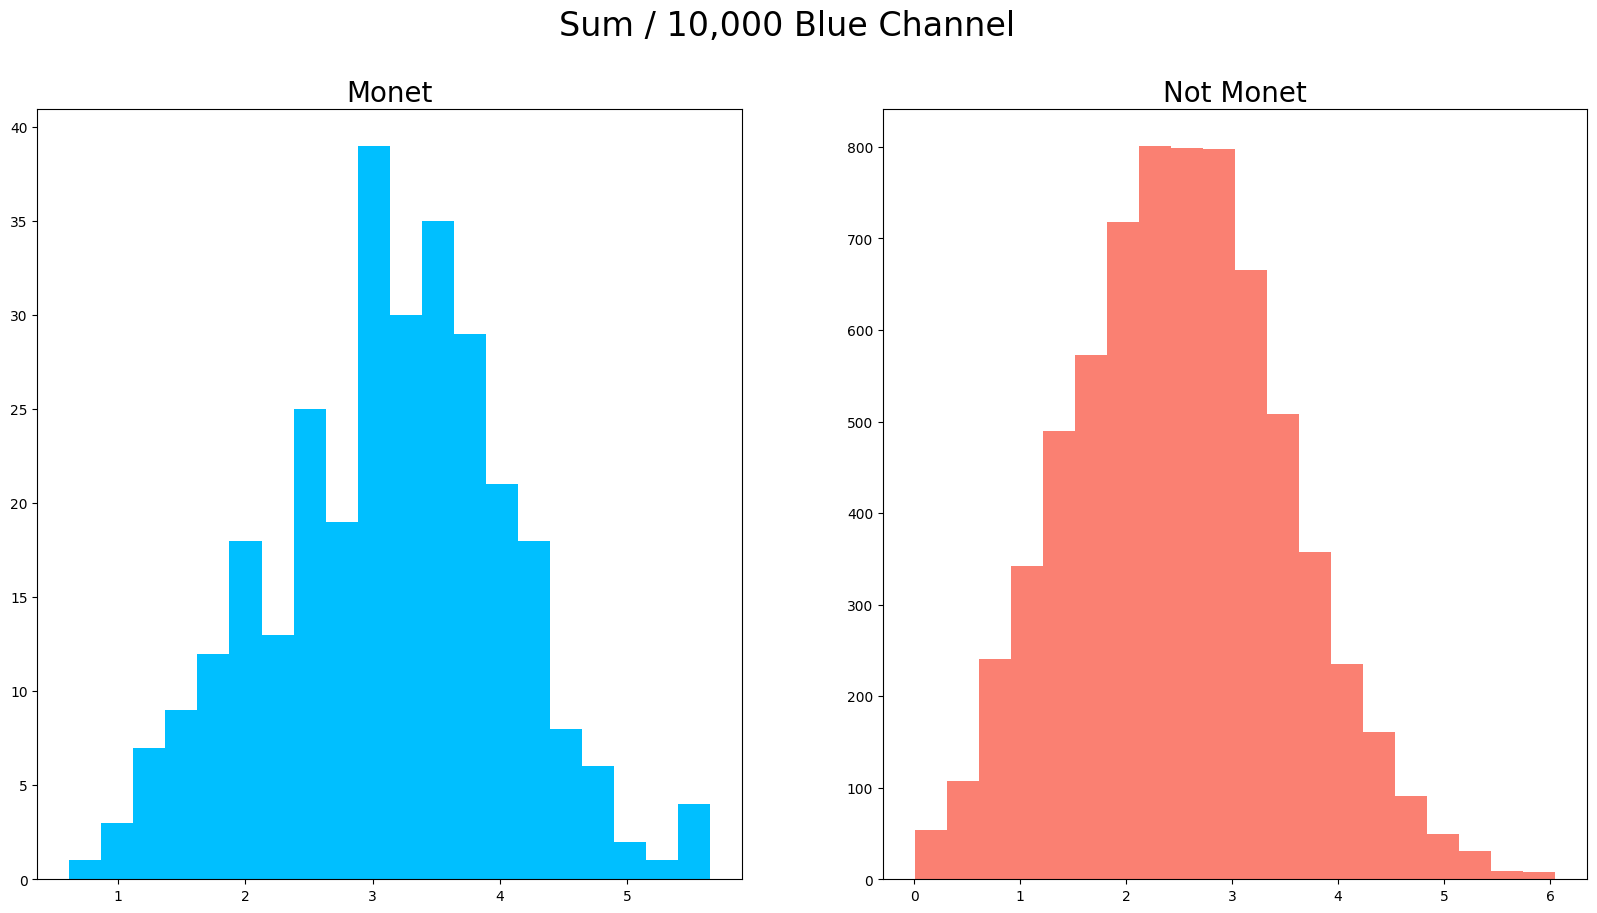

In [9]:
# Sum All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_all_channels_monet)/10000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_all_channels_photo)/10000, bins=20, color='orange');
fig.suptitle('Sum / 10,000 All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Sum Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_red_channel_monet)/10000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_red_channel_photo)/10000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000 Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Sum Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_green_channel_monet)/10000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_green_channel_photo)/10000, bins=20, color='orange');
fig.suptitle('Sum / 10,000 Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Sum Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_blue_channel_monet)/10000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_blue_channel_photo)/10000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000 Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);

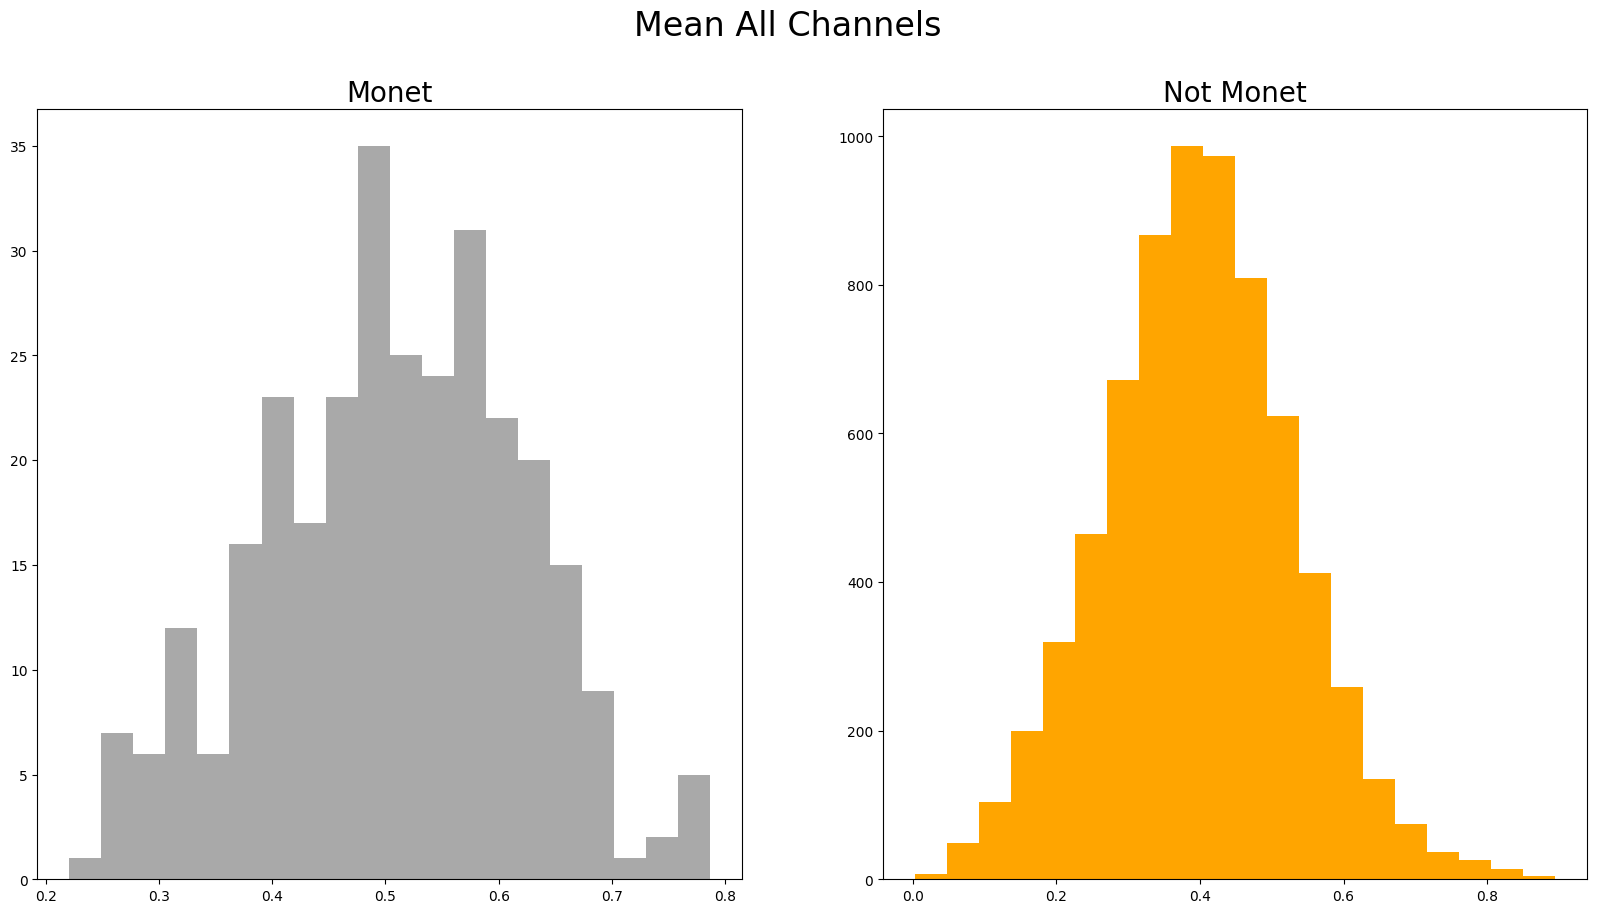

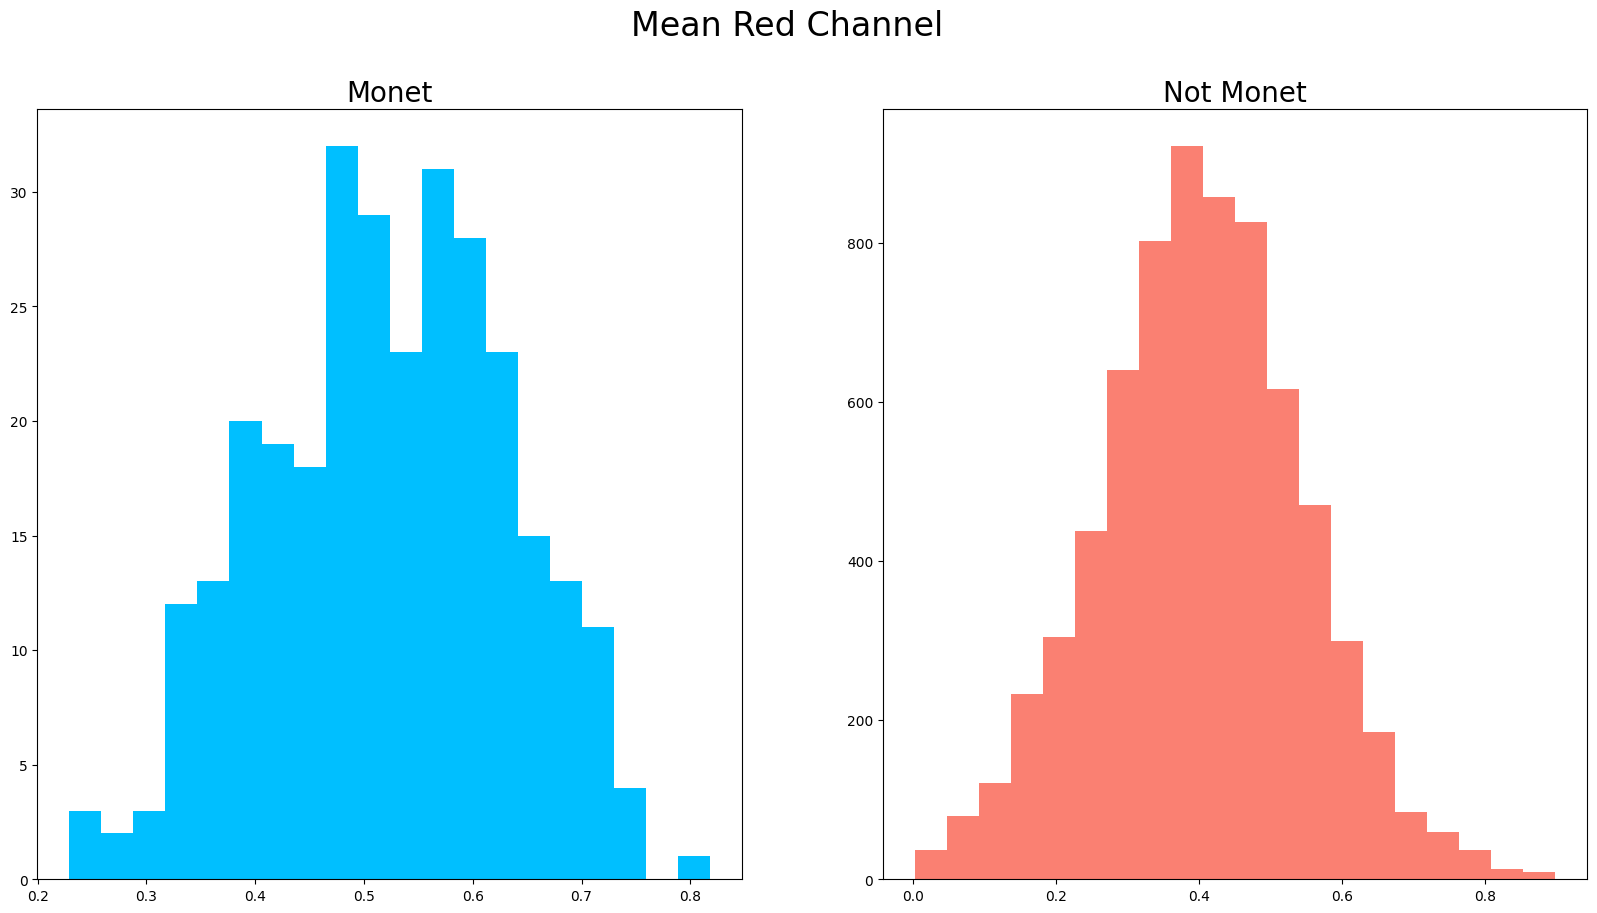

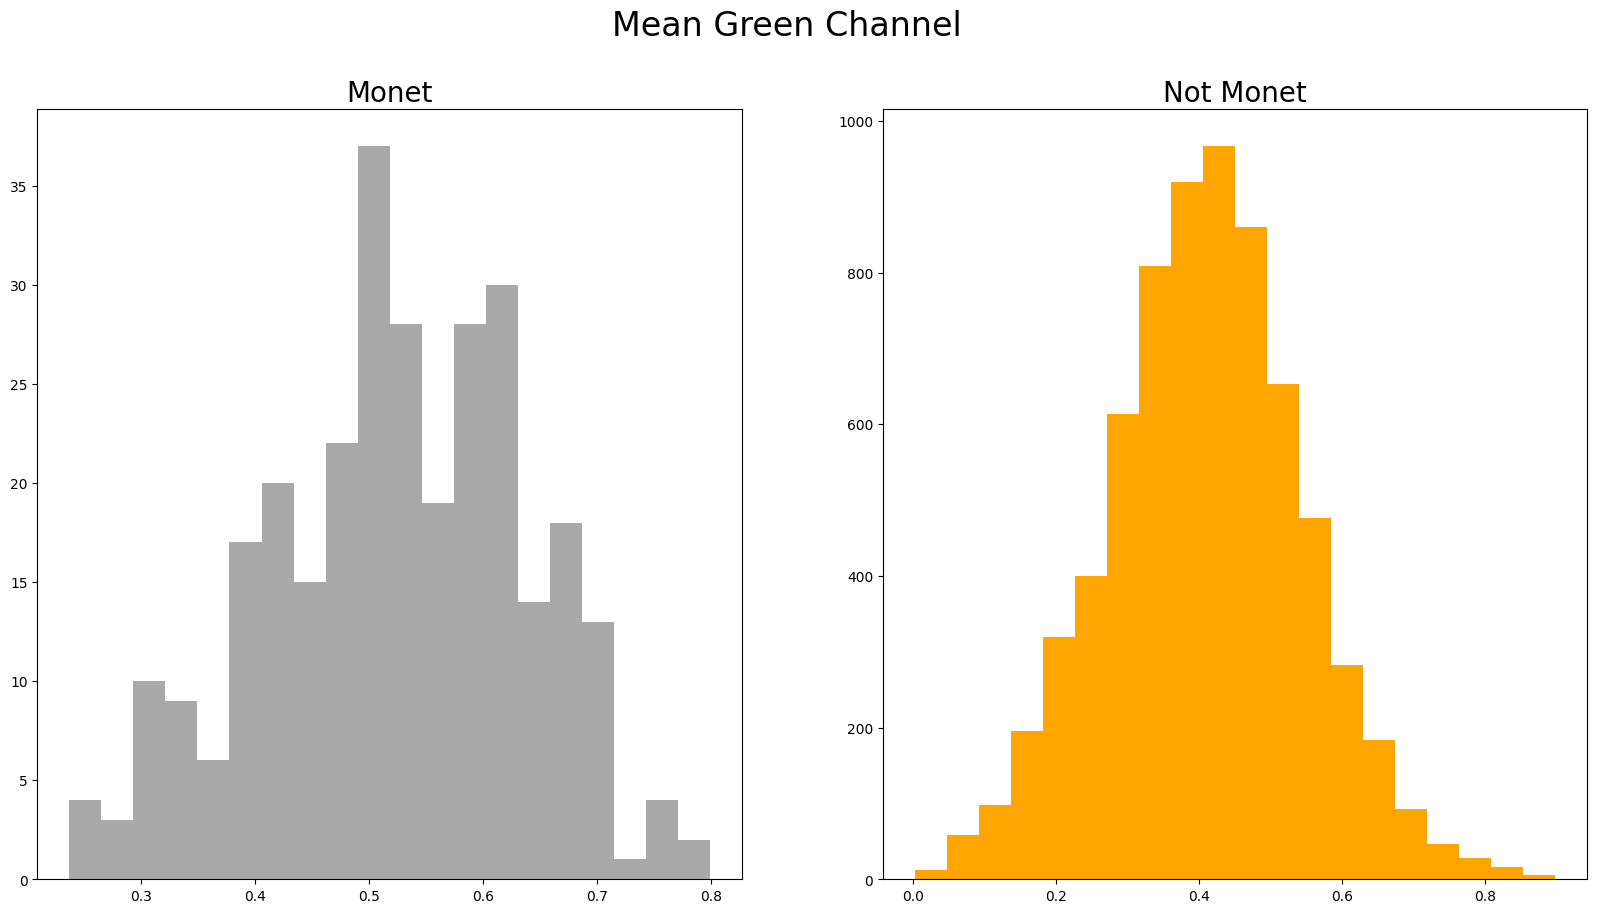

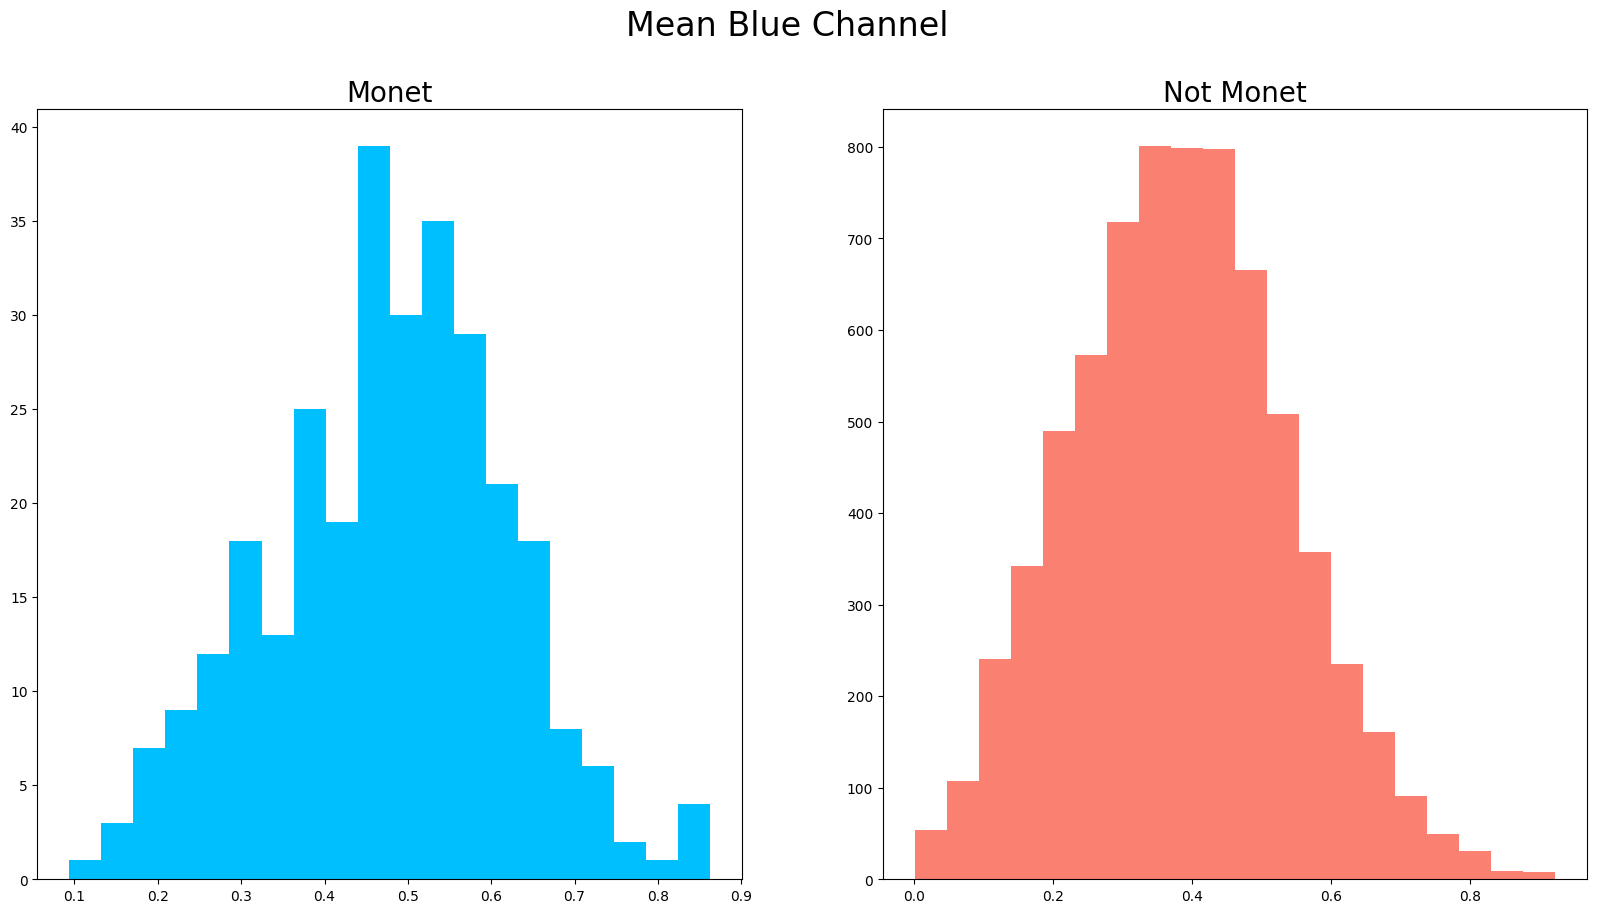

In [10]:
# Mean All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_all_channels_monet, bins=20, color='darkgray');
axes[1].hist(mean_all_channels_photo, bins=20, color='orange');
fig.suptitle('Mean All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Mean Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_red_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_red_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Mean Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_green_channel_monet, bins=20, color='darkgray');
axes[1].hist(mean_green_channel_photo, bins=20, color='orange');
fig.suptitle('Mean Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);



# Mean Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_blue_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_blue_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);

The sum distributions all look somewhat normally distributed. The photo images have a wider distribution. The photo images also look slightly shifted to the left. We also see a more unified and clear peak usually across three bins in the photo images. One thing to call out is that we have significantly more photo images than Monet images, so we may be running into a scenario where too little data on the Monet plots shows up as false shape signals. We also need to be careful in that we are comparing Monet images to non-Monet images, but the actual test of the model will be to transform the non-Monet images into Monet images. What we see here is some evidence that there is at least a difference between the Monet and non-Monet images to start with.

The same trends of wider distributions, left-shifted distributions, and more solid peaks apply as well for the mean plots. Of the two, I prefer the mean plots to the sum plots. Each of the RGB channels have their peaks around 100 for mean pixel value for the photo images. It is a little murkier for the Monet images, with the peaks not being as thoroughly defined as in the photo images, though the mean does look higher.

It is not quite clear yet what exploratory analysis will help for cleanup or for modeling since the image data looks clean as of now and because much of what we would like to look at are the modified or generated images from the GAN, but we do not have those before modeling. So, we can return back to EDA if we run into more during modeling that needs further exploration.

So, for now, we will jump into modeling.

## Modeling

(My overall take on GANs to start here comes from what I learned in the Introduction to Generative AI course in the MSCS curriculum but available as an elective for MSDS students.)

We will use GANs for modeling. A generative adversarial network (GAN) is a machine learning approach or architecture (network) that leverages two neural networks that compete against one another (adversarial) to generate (generative), in this project, new images. The two networks are the generator and the discriminator.

The GAN takes in a training set of images, in this case the Monet images. The generator starts out by creating random noise, a mapping to random pixels. The discriminator then takes the generator's images and the training set and tries to discriminate the two from one another, classifying both the real and fake images into real and fake labels by drawing discrimination boundaries that keep in the real images and keep out the fake images. The generator takes the feedback from the discriminator and tries to move the fake images closer towards the real images, adjusting pixels to get them closer and eventually beyond the discrimination boundary. This back and forth cycle repeats until the generator if able to create images that are close enough to the real images that the discriminator can no longer tell them apart. At that stage, we have trained a generator to take in inputs and output real images, real meaning indistinguishable from the training images to the discriminator.

CycleGAN transforms an image to match characteristics found in another image. The common example from the original research paper for CycleGAN is using this model to take an image of a horse as input and output the same image but with a zebra and vice versa.

We will stick with CycleGAN for this iteration of the project. The main alternative that I would like to test out in future iterations is creating new images from scratch with Monet characteristics, not applying Monet-like transformations to a set of input images.

Image-to-image translation -- converting one image into a modification of another -- typically requires paired images with the change between the pairs being what we want the model to encode and then apply to a new set of input images. The requirement to have these pairs of images for training is pretty onerous. One way around this would be to perform image-to-image translation without needing the paired images. In this case, we could have input images that demonstrate the translation we want to apply but without the translation being applied to the same images.

For example, if we want to convert winter scenes into summer scenes, paired image-to-image translation asks us to provide pairs of images where the training set has images of the same scene but with one in winter and the other in summer. We would like to remove this requirement of needing the same training images in both domains of summer and winter, instead only needing training images in each domain in general but not the same image in each domain. This is called unpaired image-to-image translation. Unpaired translation is an unsupervised approach, excepting the fact that we have two labeled sets in terms of the domain we are looking for the model to pick up on, whereas paired translation is a supervised one.

CycleGANs perform unpaired image-to-image translation, identifying the characteristics of winter and summer in the images without needing to have pairs of images in both seasons, and then it lets us apply the translation from one season to another to new input images. Since this project has unpaired images in the training set, it lends itself to use of CycleGANs for translating the style of images in one domain to the other, from non-Monet style to Monet style.

### CycleGAN Architecture

To explain here, we will use two domains of images: summer and winter.

CycleGANs add extra pieces to the base GAN architecture to accommodate unpaired data. 

CycleGANs use two generators and two discriminators, or, alternatively, two GANs. We are interested in image translation in both directions, so we train a GAN in each direction. While being able to translate images in both directions may be useful, CycleGAN uses this bi-directional architecture to minimize cycle consistency loss. (Note that cycle consistency loss is also called reconstruction error). We explore cycle consistency when we feed a summer image into the model to get a winter image, and then we take that winter image and send it back through the second model to convert it back into a summer image. We then compare how different the image that went both ways through the model is to the original summer image. Cycle consistency loss is the difference between these two images.

Cycle consistency is required to address mode collapse. This is when the generators keep producing the same output image regardless of the input. Some CycleGANs resulted in the generators learning that they can beat the discriminators by producing the same output image each time. When we translate the output image back through the model in the opposite direction and compare that output with the original input, we make sure the model does not fall victim to mode collapse.

One interesting aspect of cycle consistency is that it gives us paired data. The intermediate state gives us an image in the opposite season. Once the model is trained and accurate, we end up with pairs of images in both seasons.

Combining the previous two forms of loss, the objective function includes the adversarial loss of the first generator, the adversarial loss of the second generator, and the cycle consistency loss.

For photo generation from paintings, we include an additional loss: identity loss. We measure identity loss when we take a summer image and pass it through the GAN that converts winter images to summer images. Since we are starting with a summer image, the translation should not affect the output, meaning the "generated" summer image that moves through the model should match the original summer image. CycleGAN also minimizes identity loss as part of its objective function.

So far we have focused on the role of the two generators. The discriminators use PatchGAN. PatchGAN functions like normal discriminators but at a zoomed out level. An implementation of PatchGAN may use 70x70px patches (as the original CycleGAN paper does). This means that instead of the discriminator returning a single score for classifying the entire image at once, it instead provides a score for each 70x70 patch, moving across the image like a convolutional filter. It then averages each of the responses to provide a single discriminator value.

The original GAN paper also provides architecture decisions such as using 3 convolutional layers in the generators, using 9 residual blocks in the intermediate layers, using instance instead of batch normalization, and more. We may use some or all of these decisions in our modeling below.

There are two other interesting items to call out before jumping into modeling. First is that many CycleGAN implementations use a U-Net architecture. This architecture uses convolutional layers to downsample, transposed convolutions to upsample, and skip connections between different layers. Downsampling in this context is reducing the size of the data, and upsampling is increasing it. Note that the original GAN paper uses a residual neural network (ResNet) instead of a U-Net.

The last interesting item is that we can think of CycleGANs as adversarial autoencoders. Autoencoders are models that convert an input to a reduced or translated space and then convert that reduced or translated space back to the original in encoding and decoding cycles. We can think of CycleGANs as encoding an image to the style of the other image as the encoding step. We then engage the cycle consistency step by converting the translated image back to the original domain.

CycleGANs can capture the characteristics and style of a collection of works, not just the style of one work. In this project, we are capturing the style of Monet paintings and converting input photos into the style of those paintings. We will largely follow the TensorFlow CycleGAN and pix2pix tutorial in the references section below. Due to the complexity of what we are building and how many hyperparameters we can change, we will stick closely to the TensorFlow tutorial. 

I will likely try to do more linking between the code and the theory rather than deviating way off track from the code. Not sure if we are supposed to code our own CycleGAN solution from scratch, but that seems like a stretch due to the complexity of the model.

Let's get to building. 

### Gimme a Generator

First we build the generator. Keras's community implementation of instance normalization is deprecated, but they point to this spreadsheet that indicates that we can use GroupNormalization with groups=-1 to recreate instance normalization.

https://docs.google.com/spreadsheets/d/1YMPudb7Otqx_TQu_oTHMm5IRZolyPcah8-qkMs_wI-I/edit?gid=0#gid=0

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GroupNormalization

In the TensorFlow docs, check out the third paragraph after the block with default values to confirm how to perform instance normalization.

We mirror the test in the TensorFlow docs by encoding an image. One pass of the encoder trims the image dimensions in half for each dimension due to the strides parameters in the convolutional layer. We then decode the encoded image, expanding the autoencoder code layer back out to the input image's original dimensions.

In [11]:
def encode(n_filters, filter_size):    
    return models.Sequential([
        layers.Conv2D(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        # Unlike the pix2pix tutorial, we want instance normalization for all encoders
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
    ])

def decode(n_filters, filter_size):
    return models.Sequential([
        # We are reversing the operations of the encoder, so we match the parameters
        layers.Conv2DTranspose(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        # The tutorial applies 0.5 dropout to the first three layers only
        , layers.Dropout(0.25) # We can play with this as another hyperparameter to explore
        # We use ReLU instead of LeakyReLU here since we want the decoder output to be positive
        , layers.ReLU()
    ])

In [12]:
print(encode(3, 4)(tf.expand_dims(next(iter_monet), 0)).shape)
print((decode(3, 4)(encode(3,4)(tf.expand_dims(next(iter_monet), 0)))).shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


To repeat, the functions above create the encoder and decoder functions for an autoencoder. The goal is to repeat each of these as much as needed to produce the desired latent information layer in between. This autoencoder setup is the foundation for the U-Net that takes the place of the ResNet in the original CycleGAN paper. But we still need to add in the repeated encodings and decodings along with the skip connections to fill out the U-Net.

Note that we deviate from the TensorFlow pix2pix tutorial in that we include instance normalization on all encode steps instead of batch normalization on a subset. We also apply a dropout layer with a 0.25 dropout frequency parameter instead of applying dropout only to the first three layers.

Next we need to combine the encoding and decoding steps into a generator model, implementing the full U-Net. We will encode the input image down to a 1x1 output with 512 (or however many filters we choose) channels. We then build the image back up to original dimensions and channels.

It is not clear to me yet if we should treat the number of filters and the size of the filters as hyperparameters to test out. These values seem pretty common, but it may be that all the sources I am looking at are copying a smaller number of sources that used these values. But, these are both hyperparameters we can return to to see what happens if we play with them.

We track the skips list so we can add the output of a decoding layer with the output of the matching encoding layer. For instance, if we have 10 input layers, we encode each in order. Then, when we decode the first layer in the decoding stack, that corresponds to the final output layer of the encoding stack. We add the output of the decoding stack to the second-to-last output of the encoding stack, so we line up the decoding of the original layer 10 encoding with the output of the original layer 9 encoding. This applies the version of skip connections that we use in U-Net.

In [13]:
def gimme_a_generator():
    encoding_stack = [
                         # Comments show output image dimensions minus number of filters
        encode(64, 4)    # 128x128
        , encode(128, 4) # 64x64
        , encode(256, 4) # 32x32
        , encode(512, 4) # 16x16
        , encode(512, 4) # 8x8
        , encode(512, 4) # 4x4
        , encode(512, 4) # 2x2
        , encode(512, 4) # 1
    ]

    decoding_stack = [
        decode(512, 4)   # 2x2
        , decode(512, 4) # 4x4
        , decode(512, 4) # 8x8
        , decode(512, 4) # 16x16
        , decode(256, 4) # 32x32
        , decode(128, 4) # 64x64
        , decode(64, 4)  # 128x128
    ]

    final_decoding_layer = layers.Conv2DTranspose(
        3
        , 4
        , strides=2
        , padding='same'
        , activation='tanh'
    )                    # 256x256

    inputs = layers.Input((256, 256, 3))

    translated_images = inputs

    # Apply each encoding layer to the inputs, passing the encoding output as the next input
    skips = []
    for endecoder in encoding_stack:
        translated_images = endecoder(translated_images)
        skips.append(translated_images)

    # We need to line up the associated output to add together for the skip connections
    skips = reversed(skips[:-1])

    # Apply each decoding layer and combine with the matching output from the encoding loop
    for decoder, skip in zip(decoding_stack, skips):
        translated_images = decoder(translated_images)
        translated_images = layers.Concatenate()([translated_images, skip])

    # This spreads the image back out to three channels and full 256x256 dimensions
    translated_images = final_decoding_layer(translated_images)

    return tf.keras.Model(inputs=inputs, outputs=translated_images) 

Again, to check against the tutorial output, we see that the autoencoder is working as expecting. We repeatedly encode down to a 1x1x512 representation of an input image. We then repeatedly decode while adding skip connections to decoding outputs to get back up to a 256x256x3 generated image. It seems obvious to me now, but the generated image we are looking for is the the decoding layers applied to the 1x1x512 input. We just happen to choose an architecture where we first convert an image into that 1x1x512 representation, but it helps me to think of the generation as really being that second half with the autoencoder, though technically it is the entire model.

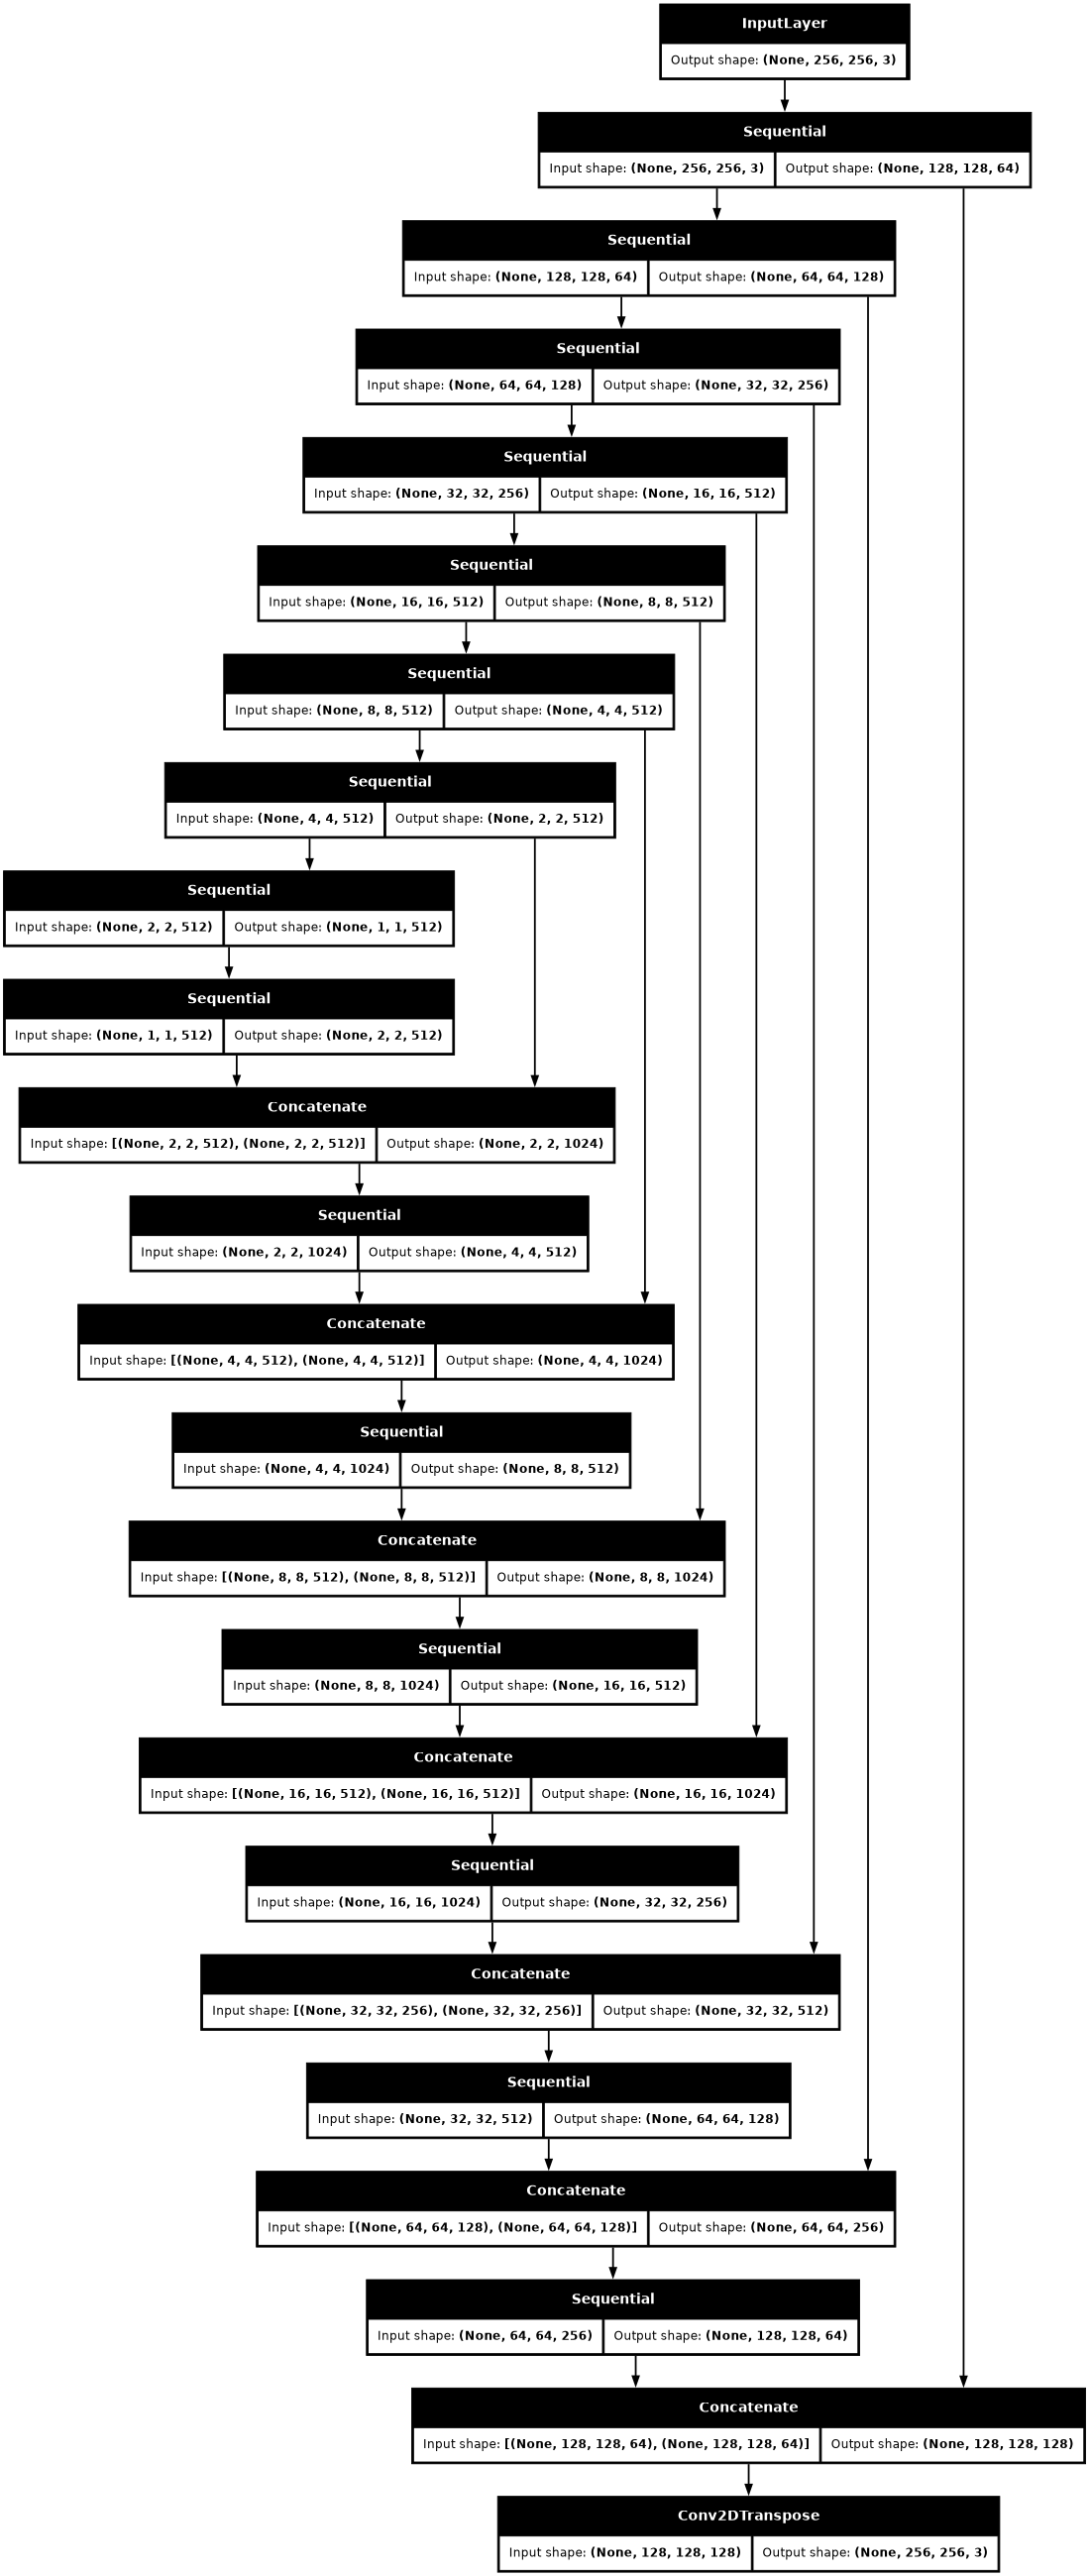

In [14]:
generator = gimme_a_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

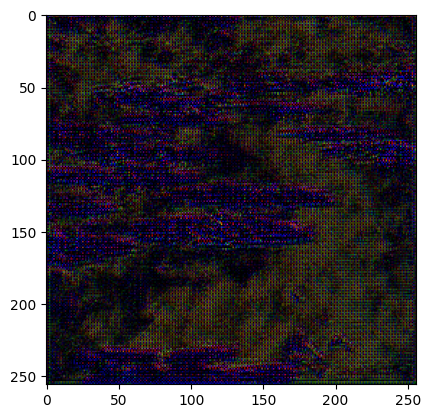

In [15]:
plt.imshow(generator(next(iter_monet)[tf.newaxis, ...], training=False)[0,...]);

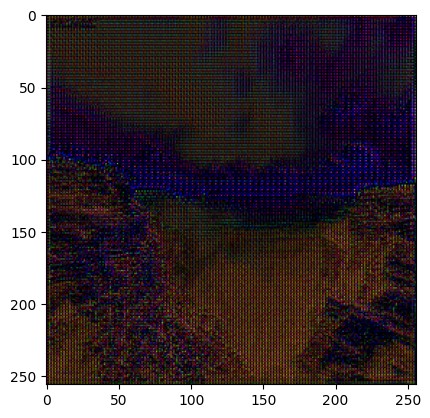

In [16]:
plt.imshow(generator(next(iter_photo)[tf.newaxis, ...], training=False)[0,...]);

In [17]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

### Are There Any Discriminators Out There?

The CycleGAN discriminator is a PatchGAN that tries to determine if each equally sized patch of an image is real or generated. This is in contrast to determining if the image as a whole is real or generated in one go. The original CycleGAN paper uses 70x70 patches.

We will use the same `encode` building blocks from above as part of the discriminator architecture.

In [18]:
def gimme_a_discriminator():
    inputs = layers.Input((256, 256, 3))

    out = models.Sequential([
        layers.Input((256, 256, 3))
        , encode(64, 4)          # 128x128
        , encode(128, 4)         # 64x64
        , encode(256, 4)         # 32x32
        , layers.ZeroPadding2D() # 34x34
        , layers.Conv2D(
            512
            , 4
            , strides=1
            , use_bias=False
        )                        # 31x31
        # Instance normalization for CycleGAN instead of batch normalization in pix2pix
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
        , layers.ZeroPadding2D() # 33x33
        , layers.Conv2D(
            1
            , 4
            , strides=1
        )                        # 30x30
    # concanate keeps the same height and width but extends the color channels to 6
    ])(inputs) # 256x256

    return tf.keras.Model(inputs=inputs, outputs=out)

Similar to above, we will check the discriminator with similar code to what is in the TensorFlow tutorial. Since we package each layer into a sequential model, we lose the intermediate steps in the following output, but we do see that the inputs and outputs at each stage match what we see in the tutorial and what we expect based on dimension analysis in the code block above.

We also see below a heatmap where the discriminator is identifying similarity and difference in patches. Note the axis ranges in the heatmap are 30x30 as expected based on the final convolutional layer in the discriminator

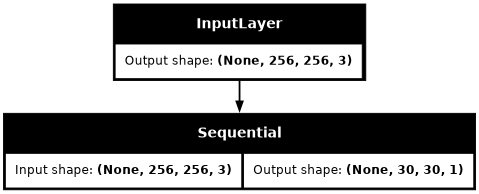

In [19]:
discriminator = gimme_a_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64) 

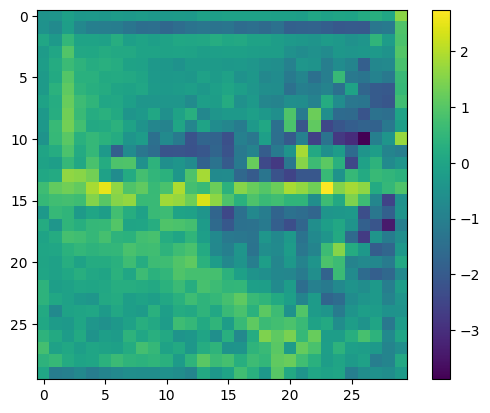

In [20]:
n = next(iter_photo)[tf.newaxis,...]
gn = generator(n)

# plt.imshow(discriminator([n, gn], training=False)[0, ..., -1]);
plt.imshow(discriminator(gn, training=False)[0, ..., -1]);
plt.colorbar();

In [21]:
discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

### But What If I Lose?

While we are on the generator, we will define the generator loss. We will now pivot from the pix2pix tutorial back to the CycleGAN tutorial. pix2pix has labeled pairs, and it passes those into the loss function. CycleGAN does not have paired data, so we need an alternative way to line up two images to calculate loss. In walk cycle consistency (described earlier) and cycle consistency loss, though the general loss approach is similar to what we see in pix2pix.

We will use sigmoid cross-entropy loss. Sigmoid cross-entropy is similar to cross-entropy in that it compares the output distribution to the real distribution, but it produces a probability from the output of the model rather than 0s or 1s. In this case, we are comparing the input images to the translated and reverse-translated images with cycle consistency loss, so all the real images are 1s.

The discriminator loss follows similar logic, but it calculates separate real and generated image losses and then averages them. We compare the real images against a tensor of 1s and the generated images against a tensor of 0s since we know which are real and which are generated.

The cycle consistency loss takes the pixel value differences across images and reduces those down to a single scalar mean value for them. Ideally this is 0 if sending an image both directions through the generators returns a matching image to the original input.



In [22]:
# Lambda controls the magnitude of the effect of the cycle consistency loss.
# A higher lambda means cycle consistency loss plays a larger role in relation
# to adversarial loss. A lower lambda flips that importance.
lambda_param = 10

def generator_loss(generated_image):
    # from_logits tells the loss function to apply the sigmoid activation function
    return losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(generated_image)
        , generated_image
    )

def discriminator_loss(real_image, generated_image):
    loss_real = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_image), real_image)
    loss_generated = losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_image), generated_image)
    return (loss_real + loss_generated) * 0.5

def cycle_loss(real_image, cycled_image):
    return lambda_param * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - cycled_image))

def identity_loss(real_image, generated_image):
    return lambda_param * 0.5 * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - generated_image))

### Optimizers

We will stick with Adam for the optimizer for both generators and both discriminators. This matches the strategy in the original CycleGAN paper. We could test out other optimizers, but that would be lower down on my list of hyperparameters to change.

Tutorials I have looked at tend to configure the optimizers the same, but this could be an area to explore if we need to for performance purposes, both in changing the learning rate and decay values but keeping them the same across optimizers as well as having different values across optimizers.

In [23]:
optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Checkpoints and Managing Runtime

One aspect of training CycleGANs I am worried about is the amount of time for iteration. We have four models inside the one CycleGAN. There are a ton of hyperparameters we can adjust. We would ideally have an incremental strategy where we change one hyperparamter at a time, but, due to the paired nature of the models that make up the CycleGAN, we may want to add both individual changes but also paired changes. 

Regardless, the prospect of how to slowly make your way through hyperparameter tuning with such a complex model is a bit overwhelming. One element that can help with this is utilizing TensorFlow checkpoints and saving models. We can explore hyperparameters, let TensorFlow handle saving the top n performing models (as one metric), and even manually save models at different states to disk so we do not have to start from scratch each time. This allows us to explore smaller numbers of epochs to see how changes affect outputs, and then we can circle back to partially trained models based on smaller scopes of performance to let them run longer, if needed, to continue improving model performance.

Checkpoints allow us to store weights at different epochs of training.

In [24]:
checkpoint = tf.train.Checkpoint(
    generator_monet_to_photo=generator_monet_to_photo
    , generator_photo_to_monet=generator_photo_to_monet
    , discriminator_monet=discriminator_monet
    , discriminator_photo=discriminator_photo
    , optimizer_generator_monet_to_photo=optimizer_generator_monet_to_photo
    , optimizer_generator_photo_to_monet=optimizer_generator_photo_to_monet
    , optimizer_discriminator_monet=optimizer_discriminator_monet
    , optimizer_discriminator_photo=optimizer_discriminator_photo
)

checkpoint_mgr = tf.train.CheckpointManager(
    checkpoint
    , f'{out_dir}'
    , max_to_keep=5
)

if checkpoint_mgr.latest_checkpoint:
    checkpoint.restore(checkpoint_mgr.latest_checkpoint)

### Train Me Please

There is a lot going on in the following `train_step` function. This function performs the training in each epoch. We send real Monet and photo images into the associated generators and discriminators, calculate the associated losses, and calculate gradients with their associated optimizers. There are comments before lines of code indicating which of those are happening. Note that the `@tf.function` decorator lets TensorFlow map out a graph for the operations in the function. The first invocation of the function runs as normal python. Subsequent invocations take advantage of optimizations in TensorFlow.

In [25]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )

In [26]:
def gimme_images(model, test_input):
    pred = model(test_input)
    
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(15,15)
    )

    axes[0].imshow(test_input[0].numpy().squeeze())
    axes[1].imshow(pred[0].numpy().squeeze())

    axes[0].set_title('Real Image', fontsize=24)
    axes[1].set_title('Generated Image', fontsize=24)

    # Turn axis labels and grids off
    for ax in axes.ravel():
        ax.set_axis_off()

    fig.tight_layout()
    plt.show()

With all that setup in place, we are now ready to build the final loop that runs for each epoch.

In [28]:
ds_monet = parsed_images_monet.batch(1)
ds_photo = parsed_images_photo.batch(1)
sample_photo = [image for image in ds_photo.take(1)]

In [ ]:
n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

### Who Wants to Learn Anyways?

In good news, the first pass of modeling technically works, though some of the hyperparameters need attention since the generated images are not getting progressively more Monet-ish. We largely stuck with default hyperparameter values above based on what is in the TensorFlow tutorial. This is in most part because we need some baseline to start from, and I am not sure what else to use without going through a couple of iterations of hyperparameter tuning.

The core issue we see is that the generated images are patchy or blocky in some epochs, are mostly white with small vertical stripes of colors in other images, and more. The fact that we are not seeing either no improvement or continal improvement in the quality of the generated images hints to me that we should start by looking at the learning rates, in particular at lowering the learning rate. My intuition is that we are watching the model bounce around a minima, leading to the chaotic output from epoch to epoch. 

We have four learning rates we can adjust -- one for each of two generators and one for each of two discriminators. We will start by seeing how changes to learning rates affect model performance when we change the learning rate but keep it the same across all four models.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

Lowering the learning rate from 0.0002 to 0.00002 cleans up some of the patchiness and inconsistencies between epochs when run for 5 epochs. The generated images start out fuzzier, but they gain clarity as the epochs increase. There does appear to be some of the pastel-ish style of the Monet paintings showing up in the generated images as well.

This learning rate looks promising for running at higher epochs. It also supports the hypothesis that the original learning rate was too high, resulting in unexpected jumps in display from epoch to epoch at the previous higher learning rate.

Next we will lower the learning rate further.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.000002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.000002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.000002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.000002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

This even lower learning rate still looks preferable to the original learning rate. We see continual improvement, but the change from epoch to epoch is less than in the previous training loop, so we may have overshot lowering the learning rate. My preference is to test out higher epochs on the previous learning rate before adding to this one.

Next we see what happens if we increase the learning rate from the original.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

These look unintelligible. They are patchy or blocky like some with the original learning rate. We see some semblance of patterns here, but they again feel like the optimizers are bouncing across minima, resulting in minor changes to the general theme in the outputs. I think this is enough evidence for us to stick with the smaller learning rate. Before adding in more epochs, we will test out one lower learning rate that is halfway between the two promising ones earlier.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00007, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00007, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00007, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00007, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

This middle rate does not appear to add much. Of the ones above, I am leaning towards a learning rate of 0.00002. We will run that model again but with more epochs to see if the bluriness clears up over a longer training horizon.

Note that I removed the previous code block for running the preferred learning rate for 15 epochs. The amount of visuals this outputs into the notebook is getting to be too many. But, 15 epochs looks promising. The bluriness starts to fade around epoch 10 to 15. I do want to see what this looks like with even more epochs, but it would help to see if there are other hyperparameters we want to tune along with learning rate before running for longer. At some point, we will also only want to output the final generated image.

### More Tuning Please

I do not want the hyperparameter tuning for this iteration of the project to balloon the scope, so, instead of changing multiple hyperparameters, I would rather choose one more to improve and then let the training run for a much higher number of epochs. Here are a couple of hyperparameters we can take a look at:
- dropout rate in the decode steps of the autoencoder
- filter sizes in the autoencoder
- filter sizes in the discriminator
- ratios between losses by changing lambda
- decay rate for the optimizers
- optimizer algorithm (though this is last on my list to explore)

Taking a look at all of these, and trying to keep the complexity as minimal as possible for right now, I think it makes the most sense to explore the decay rate for the optimizers. We are already exploring the learning rate for the optimizers, so this keeps the hyperparameter tuning for this iteration of the project in the same area. Once we identify a hopefully better performing decay rate, we will train the model with the newly selected learning and decay rates for many more epochs to see if we can get better style transfer.

We will start by modifying the decay rate only for the learning rate that we selected above. Once we are in the ballpark of improvements for decay rate, then we can look at applying those to more than one learning rate, if needed.

Since we lowered the learning rate overall, we can lower the decay rate since we are not as worried about the already lowered learning rate staying too high for too long. Then we will take a look at raising the decay rate.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.2)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.2)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.2)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.2)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.0002, beta_1=0.9)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.0002, beta_1=0.9)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.9)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.0002, beta_1=0.7)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.0002, beta_1=0.7)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.0002, beta_1=0.7)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.0002, beta_1=0.7)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.4)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.4)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.4)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.4)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
    gimme_images(generator_photo_to_monet, sample_photo)

#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')

I actually think we got lucky with the 0.00002 learning rate and the 0.5 decay rate that we tested out earlier. Changing the decay rate does have an effect, and it does allow us to be more flexible with the learning rate, but the best performing model judging by eye looks to still be the 0.00002 and 0.5 learning and decay rates.

## Results

For this iteration of the project, we are leaving some of the defaults we pulled from the TensorFlow pix2pix and CycleGAN tutorials such as the make up of the U-Net autoencoders as generators and the design of the descriminators, the base losses, and the specific hyperparameters in given layers that make those up. For the next iteration of the project, we would want to explore these hyperparameters more.

For now, we have landed on just tuning the optimizers. All four models inside the CycleGAN have the same values for learning rate and the same values for decay rate: 0.00002 and 0.5 respectively. The process for identifying this is informal in that we manually adjusted hyperparameters for 5-15 epochs and eyeballed which values resulted in the best style transfer.

The final step is to train the model for 100 epochs, a longer starting point based on preliminary research into the time scales that this model likes to run on for this problem. We will then use that trained model to style all of the photo images, zip those up into an images.zip, and submit that to the competition to see how we do in terms of score.

Speaking of score, this competition uses the Memorization-informed Fréchet Inception Distance (MiFID) score to evaluate submissions. This is a variant of the Fréchet Inception Distance (FID). FID measures the distance between two distributions by extracting features from images, modeling distributions around those features, and then comparing those distributions to determine how far apart they are. MiFID modifies FID by punishing submissions that have memorized training samples, using cosine similarity to determine if the model is spitting out memorized outputs each time. We are hoping for a smaller MiFID.

And, with that, ther last step is to perform the final training and get out competition score.

In [ ]:
generator_monet_to_photo = gimme_a_generator()
generator_photo_to_monet = gimme_a_generator()

discriminator_monet = gimme_a_discriminator()
discriminator_photo = gimme_a_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 3

for epoch in range(n_epochs):
    start = time.time()

    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} s\n')
    
#     if (epoch+1) % 5 == 0:
#         checkpoint_save_path = checkpoint_mgr.save()
#         print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_save_path}')
        
gimme_images(generator_photo_to_monet, sample_photo)

In [ ]:
if os.path.exists(f'{out_dir}/imgs'):
    shutil.rmtree(f'{out_dir}/imgs')
os.makedirs(f'{out_dir}/imgs')

n=1
for img in df_photo:
    pred = (generator_photo_to_monet(img, training=False)[0].numpy().squeeze() * 255).astype(np.uint8)
    tf.keras.utils.save_img(f'{out_dir}/imgs/{n}.jpg')
    n += 1
    


In [ ]:
shutil.make_archive(f'{out_dir}/images', 'zip', f'{out_dir}/imgs')

In [ ]:
shutil.rmtree(f'{out_dir}/imgs')

## Conclusion

- Balance between resources, time, and model exploration

## References

Working with TensorFlow TFRecords
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564

Evaluation metrics
- https://arxiv.org/abs/1706.08500 (FID)
- https://www.kaggle.com/c/generative-dog-images/overview/evaluation (MiFID)

GANs
- https://www.geeksforgeeks.org/generative-adversarial-network-gan/
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://machinelearningmastery.com/what-is-cyclegan/
- https://neptune.ai/blog/gan-loss-functions
- https://www.geeksforgeeks.org/spatial-resolution-down-sampling-and-up-sampling-in-image-processing/
- https://www.youtube.com/watch?v=5jziBapziYE

Original CycleGAN paper and docs from original authors
- https://junyanz.github.io/CycleGAN/
- https://arxiv.org/pdf/1703.10593

CycleGAN references used to build the models above
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.youtube.com/watch?v=4LktBHGCNfw (CycleGAN implementation)
- https://hardikbansal.github.io/CycleGANBlog/
- https://www.youtube.com/watch?v=2MSGnkir9ew
- https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

Saving Models
- https://www.tensorflow.org/tutorials/keras/save_and_load
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/
- https://machinelearningmastery.com/check-point-deep-learning-models-keras/

TPUs in Kaggle
- https://www.kaggle.com/docs/tpu
- https://www.tensorflow.org/guide/tpu